## Contents
- [1. Introduction](#1.-Introduction)
- [2. Imports](#2.-Imports)
- [3. Label Data & Train Model](#3.-Label-Data-&-Train-Model)
- [4. Model Prediction](#4.-Model-Prediction)

---
### 1. Introduction
---
To develop an improved object detection model using:
- YOLOv5l
    - Starting on pretrained weights on COCO 2017
    - with YOLOv5 default training data augmentation of:
        - colours: hu (0.015), saturation (0.7), lightness (0.4)
        - image translation (0.1), scale (0.5), flip left-right (0.5) and mosaic (applied)
        - full parameters in hyp.scratch-low.yaml file
    - with added custom augmentation of:
        - image rotation (+/-15 degrees), shear (+/-15 degrees)
<br>
<br>
- Dataset (total 1000 photos)
<br>
<br>
    - Training (total 600 photos)
        - 100 digitally generated photos of ID cards from Slovakia, Spain and Finland each (total 300)
        - 100 digitally generated photos of passports from Latvia, Russia and Greece each (total 300)
<br>
<br>
    - Validation (total 200 photos)
        - 100 digitally generated photos of ID cards from Estonia
        - 100 digitally generated photos of passports from Serbia
<br>
<br>
    - Test (total 200 photos)
        - 100 digitally generated photos of ID cards from Albania
        - 100 digitally generated photos of passports from Azerbaijan

---
## 1. Imports
---

In [1]:
# direct into the cloned repo
%cd yolov5

import torch
import os
import pandas as pd
# to display images
from IPython.display import Image, clear_output  
from roboflow import Roboflow
import matplotlib.pyplot as plt

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

f:\Edmond\03. Learning\01. Personal github\yolov5


f:\Edmond\03. Learning\01. Personal github\.conda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Using torch 1.13.1+cu117 (NVIDIA GeForce RTX 3060)


---
## 2. Label Data & Train Model
---
- using train dataset (Finland, Greece, Russia, Slovak Republic, Serbia, Latvia) 
- and val dataset (Spain, Estonia)

In [2]:
# set up environment to download dataset from roboflow
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [5]:
# download labelled dataset from roboflow
rf = Roboflow(api_key="MY API KEY")  # removed API details
project = rf.workspace("MY WORK SPACE").project("id-card-passport-detection")  # removed workspace details
dataset = project.version(18).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/id-card-passport-detection-18 in yolov5pytorch:: 100%|██████████| 2012/2012 [00:01<00:00, 1591.18it/s]


In [7]:
# baseline: transfer learn using YOLOv5l model from pretrained weights on COCO 2017val dataset, with no freezing
!python train.py --img 640 --batch 8 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5l.pt --hyp hyp.scratch-low-custom.yaml --cache

train: weights=yolov5l.pt, cfg=, data=f:\content\datasets\id-card-passport-detection-19/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github:  YOLOv5 is out of date by 6 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
fatal: cannot change to 'F:\Edmond\03.': No such file or directory
YOLOv5  2023-2-21 Python-3.10.9 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup

display train vs val losses

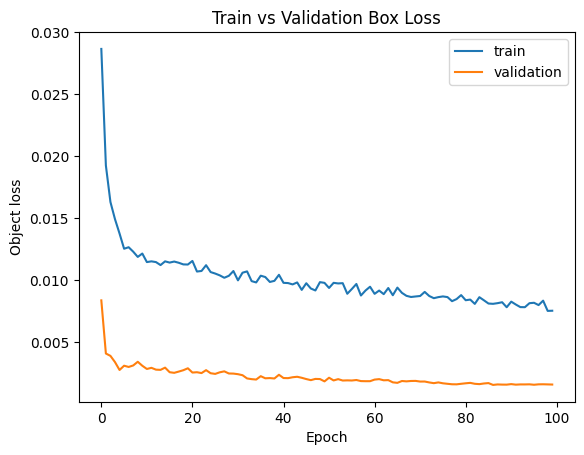

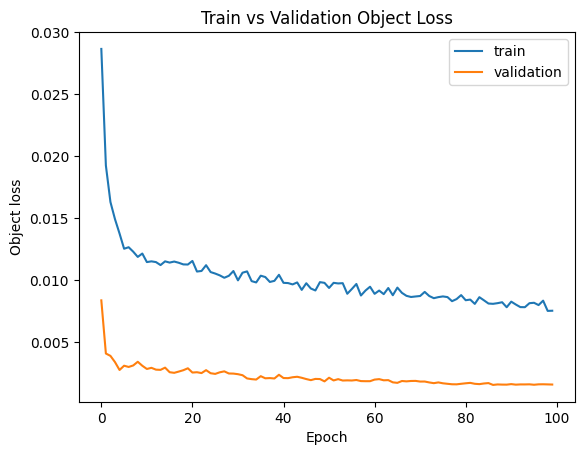

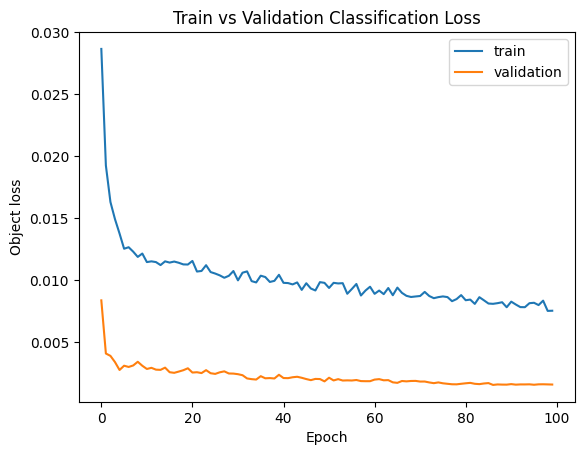

In [8]:
results = pd.read_csv("runs/train/exp18/results.csv")
x = results.iloc[:,0]
y_train_box = results.iloc[:,1]
y_val_box = results.iloc[:,8]
y_train_obj = results.iloc[:,2]
y_val_obj = results.iloc[:,9]
y_train_ls = results.iloc[:,3]
y_val_cls = results.iloc[:,10]

# plot train vs val box loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Box Loss')
plt.show()

# plot train vs val object loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Object Loss')
plt.show()

# plot train vs val classification loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Classification Loss')
plt.show()

In [9]:
# Load tensorboard to log runs, compare results between runs
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 15736), started 4:28:12 ago. (Use '!kill 15736' to kill it.)

Analysis:
- the training loss is higher than validation loss, indicating that there is more variation in sample data in the training dataset compared to the validation dataset
- comparing improved model 1 vs this model's performance:
    - this model has a higher training loss than improved model 1. This is logical as this model has 2 more augmentation modes (rotation, shear) than improved model 1.
    - this model also has a higher validation loss than improved model 1. The added augmentation may have been a source of confusion for the model training, especially when the training dataset is quite small (600 in total)

---
## 3. Model prediction
---
- on test dataset (Albania, Azerbaijan)

In [10]:
# run inference with trained weights
!python detect.py --weights runs/train/exp18/weights/best.pt --img 640 --conf 0.7 --iou 0.5 --augment --source {dataset.location}/test/images

detect: weights=['runs/train/exp18/weights/best.pt'], source=f:\content\datasets\id-card-passport-detection-18/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'F:\Edmond\03.': No such file or directory
YOLOv5  2023-2-21 Python-3.10.9 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/200 F:\content\datasets\id-card-passport-detection-18\test\images\alb_card-1-_jpg.rf.897bba35075e9f90aaa836ece4121896.jpg: 640x640 1 id-card, 272.6ms
image 2/200 F:\content\datasets\id-card-passport-detection-18\test\image

Analysis of test:
- correctly identified:
    - 95 ID cards
    - 98 passports
<br>
<br>
- wrongly identified:
    - 3 ID cards, wrongly identified as passports
    - 2 ID cards, wrongly identified as background
    - 2 passports, wrongly identified as ID cards
<br>
<br>
- this model has a similar prediction accuracy as the improved model 1. However, this model has a weaker capability in identifying objects (due to its error in identifying 2 ID cards as background)

display predicted images (commented out due to long printout)

In [ ]:
# display predicted images
# import glob
# from IPython.display import Image, display

# for imageName in glob.glob('runs/detect/exp4/*.jpg'): #assuming JPG
#     display(Image(filename=imageName))
#     print("\n")